YOLO NAS Training - UAV

Necessary Setup and Imports

In [ ]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to bu

RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

The console stream is logged into /root/sg_logs/console.log


[2024-01-04 08:00:49] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-04 08:00:49] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-04 08:00:49] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-01-04 08:00:58] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-04 08:00:58] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-04 08:00:58] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


Download Dataset

In [ ]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size,
            unit='iB',
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')

download_file(
    'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
    'hituav-a-highaltitude-infrared-thermal-dataset.zip'
)

  0%|          | 0.00/200M [00:00<?, ?iB/s]

In [ ]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('hituav-a-highaltitude-infrared-thermal-dataset.zip')

Dataset Set Up

In [ ]:
ROOT_DIR = 'hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [ ]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes
}

In [ ]:
# Global parameters.
EPOCHS = 5
BATCH_SIZE = 16
WORKERS = 8

Visualize Ground Truth Images

In [ ]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

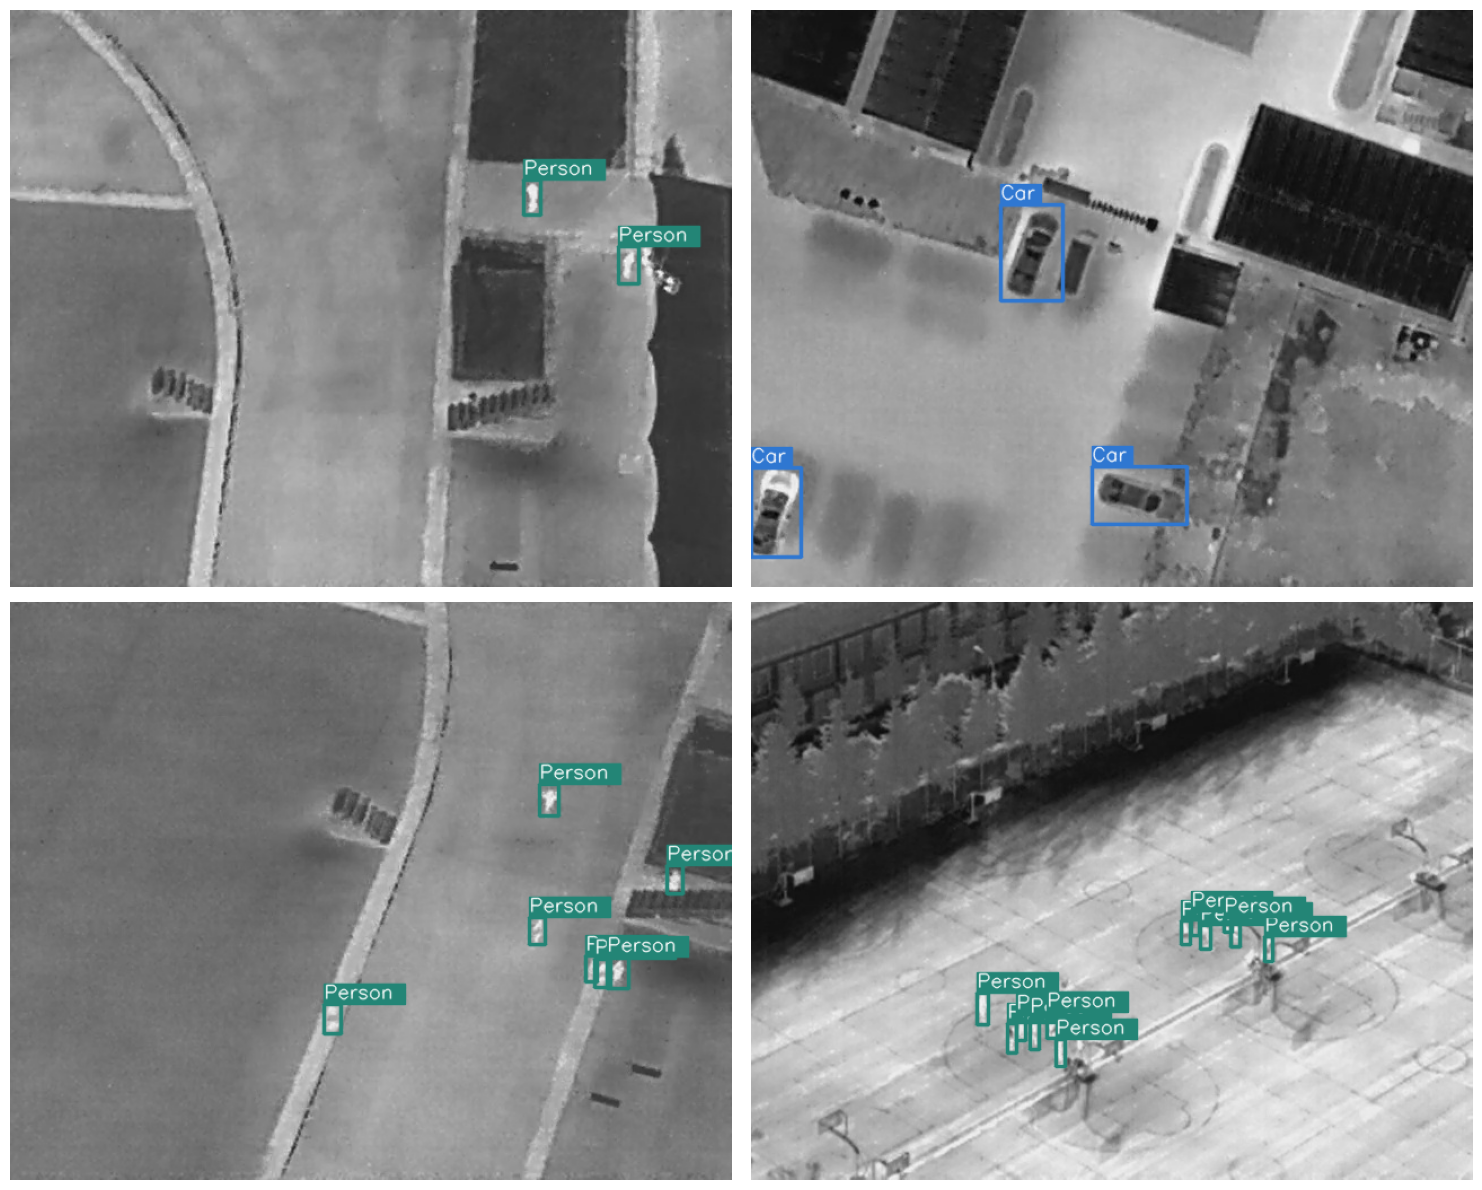

In [ ]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

Data Preparation

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2024-01-04 08:14:17] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 2008/2008 [00:01<00:00, 1737.36it/s]
[2024-01-04 08:14:19] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 287/287 [00:00<00:00, 1962.83it/s]


Transforms and Augmentation

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [ ]:
# An example on how to modify augmentations
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDi

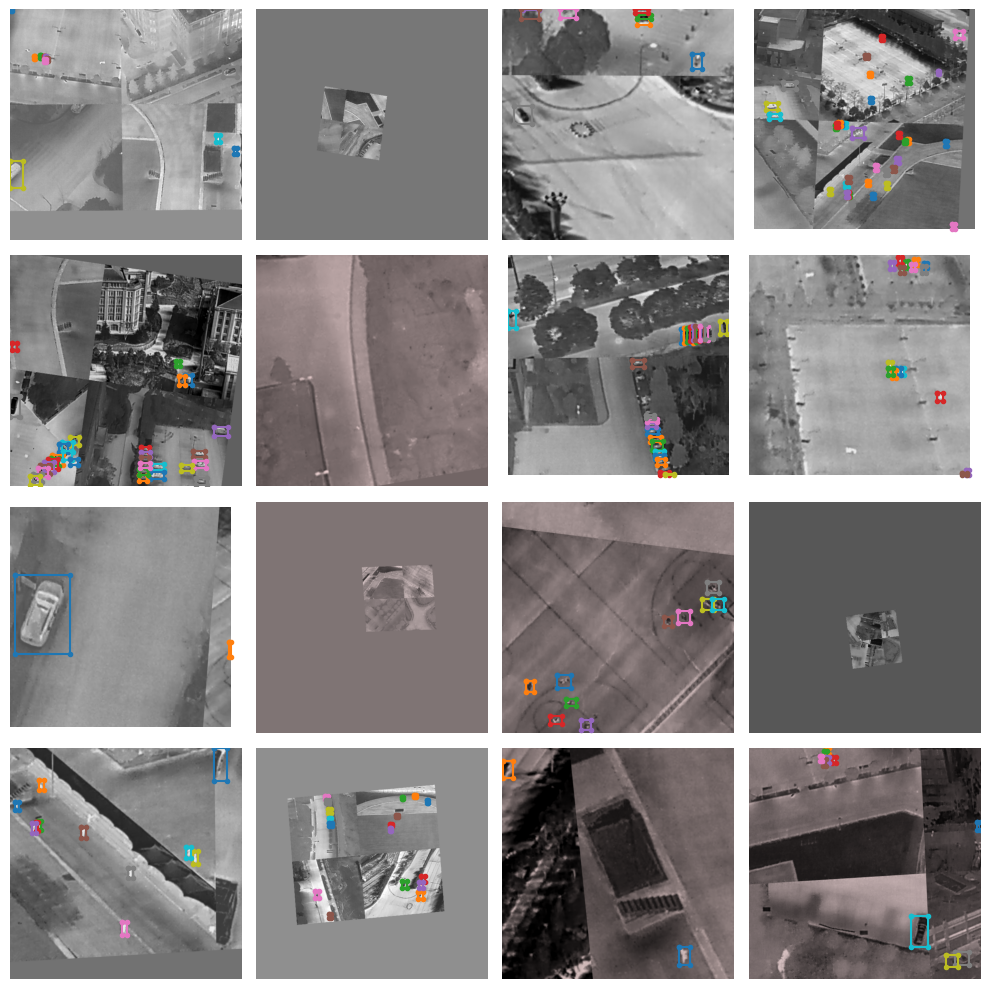

In [ ]:
# We visualize the images with augmentation here
train_data.dataset.plot(plot_transformed_data=True)

Prepare Model and Training Parameters

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
models_to_train = [
    'yolo_nas_l'
]

In [ ]:
CHECKPOINT_DIR = 'checkpoints'

Model Training

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train+'_'+str(EPOCHS)+'e',
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

[2024-01-04 08:14:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-01-04 08:14:44] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
[2024-01-04 08:14:44] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240104_081444_219847`
[2024-01-04 08:14:44] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolo_nas_l_5e/RUN_20240104_081444_219847
[2024-01-04 08:14:44] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_l_5e/RUN_20240104_081444_219847/console_Jan04_08_14_44.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is small

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2383
│   ├── Ppyoloeloss/loss_iou = 0.8242
│   ├── Ppyoloeloss/loss_dfl = 0.5666
│   └── Ppyoloeloss/loss = 3.6292
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.2745
    ├── Ppyoloeloss/loss_iou = 0.6706
    ├── Ppyoloeloss/loss_dfl = 0.4538
    ├── Ppyoloeloss/loss = 3.3989
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0469
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0225
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
[2024-01-04 08:21:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_5e/RUN_20240104_081444_219847/ckpt_best.pth
[2024-01-04 08:21:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2229612022638321


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0175
│   │   ├── Epoch N-1      = 2.2383 (↘ -1.2208)
│   │   └── Best until now = 2.2383 (↘ -1.2208)
│   ├── Ppyoloeloss/loss_iou = 0.5989
│   │   ├── Epoch N-1      = 0.8242 (↘ -0.2254)
│   │   └── Best until now = 0.8242 (↘ -0.2254)
│   ├── Ppyoloeloss/loss_dfl = 0.4213
│   │   ├── Epoch N-1      = 0.5666 (↘ -0.1453)
│   │   └── Best until now = 0.5666 (↘ -0.1453)
│   └── Ppyoloeloss/loss = 2.0377
│       ├── Epoch N-1      = 3.6292 (↘ -1.5914)
│       └── Best until now = 3.6292 (↘ -1.5914)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.952
    │   ├── Epoch N-1      = 2.2745 (↘ -1.3224)
    │   └── Best until now = 2.2745 (↘ -1.3224)
    ├── Ppyoloeloss/loss_iou = 0.5205
    │   ├── Epoch N-1      = 0.6706 (↘ -0.1501)
    │   └── Best until now = 0.6706 (↘ -0.1501)
    ├── Ppyoloeloss/loss_dfl = 0.3725
    │   ├── Epoch N-1      = 0.4538 (↘ -0.0813)
    │   └── Best until now = 0.4538 (↘ -0.0813)
    ├── Ppyoloeloss/los

Validating epoch 2: 100%|██████████| 18/18 [00:23<00:00,  1.32s/it]
[2024-01-04 08:25:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_5e/RUN_20240104_081444_219847/ckpt_best.pth
[2024-01-04 08:25:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2622086703777313


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9032
│   │   ├── Epoch N-1      = 1.0175 (↘ -0.1143)
│   │   └── Best until now = 1.0175 (↘ -0.1143)
│   ├── Ppyoloeloss/loss_iou = 0.5678
│   │   ├── Epoch N-1      = 0.5989 (↘ -0.0311)
│   │   └── Best until now = 0.5989 (↘ -0.0311)
│   ├── Ppyoloeloss/loss_dfl = 0.403
│   │   ├── Epoch N-1      = 0.4213 (↘ -0.0183)
│   │   └── Best until now = 0.4213 (↘ -0.0183)
│   └── Ppyoloeloss/loss = 1.874
│       ├── Epoch N-1      = 2.0377 (↘ -0.1637)
│       └── Best until now = 2.0377 (↘ -0.1637)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8401
    │   ├── Epoch N-1      = 0.952  (↘ -0.112)
    │   └── Best until now = 0.952  (↘ -0.112)
    ├── Ppyoloeloss/loss_iou = 0.5088
    │   ├── Epoch N-1      = 0.5205 (↘ -0.0117)
    │   └── Best until now = 0.5205 (↘ -0.0117)
    ├── Ppyoloeloss/loss_dfl = 0.3707
    │   ├── Epoch N-1      = 0.3725 (↘ -0.0018)
    │   └── Best until now = 0.3725 (↘ -0.0018)
    ├── Ppyoloeloss/loss =

Validating epoch 3: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8854
│   │   ├── Epoch N-1      = 0.9032 (↘ -0.0178)
│   │   └── Best until now = 0.9032 (↘ -0.0178)
│   ├── Ppyoloeloss/loss_iou = 0.5597
│   │   ├── Epoch N-1      = 0.5678 (↘ -0.0081)
│   │   └── Best until now = 0.5678 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_dfl = 0.3973
│   │   ├── Epoch N-1      = 0.403  (↘ -0.0057)
│   │   └── Best until now = 0.403  (↘ -0.0057)
│   └── Ppyoloeloss/loss = 1.8424
│       ├── Epoch N-1      = 1.874  (↘ -0.0316)
│       └── Best until now = 1.874  (↘ -0.0316)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9126
    │   ├── Epoch N-1      = 0.8401 (↗ 0.0725)
    │   └── Best until now = 0.8401 (↗ 0.0725)
    ├── Ppyoloeloss/loss_iou = 0.5174
    │   ├── Epoch N-1      = 0.5088 (↗ 0.0085)
    │   └── Best until now = 0.5088 (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 0.3722
    │   ├── Epoch N-1      = 0.3707 (↗ 0.0015)
    │   └── Best until now = 0.3707 (↗ 0.0015)
    ├── Ppyoloeloss/loss = 1

Validating epoch 4: 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]
[2024-01-04 08:32:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_5e/RUN_20240104_081444_219847/ckpt_best.pth
[2024-01-04 08:32:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.31311264634132385


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8308
│   │   ├── Epoch N-1      = 0.8854 (↘ -0.0546)
│   │   └── Best until now = 0.8854 (↘ -0.0546)
│   ├── Ppyoloeloss/loss_iou = 0.516
│   │   ├── Epoch N-1      = 0.5597 (↘ -0.0437)
│   │   └── Best until now = 0.5597 (↘ -0.0437)
│   ├── Ppyoloeloss/loss_dfl = 0.377
│   │   ├── Epoch N-1      = 0.3973 (↘ -0.0203)
│   │   └── Best until now = 0.3973 (↘ -0.0203)
│   └── Ppyoloeloss/loss = 1.7238
│       ├── Epoch N-1      = 1.8424 (↘ -0.1186)
│       └── Best until now = 1.8424 (↘ -0.1186)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.838
    │   ├── Epoch N-1      = 0.9126 (↘ -0.0745)
    │   └── Best until now = 0.8401 (↘ -0.002)
    ├── Ppyoloeloss/loss_iou = 0.4734
    │   ├── Epoch N-1      = 0.5174 (↘ -0.044)
    │   └── Best until now = 0.5088 (↘ -0.0355)
    ├── Ppyoloeloss/loss_dfl = 0.3497
    │   ├── Epoch N-1      = 0.3722 (↘ -0.0225)
    │   └── Best until now = 0.3707 (↘ -0.021)
    ├── Ppyoloeloss/loss = 1

[2024-01-04 08:32:28] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 5: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Inference

In [ ]:
os.makedirs('inference_results/images/', exist_ok=True)

Inference on Test Images

In [ ]:
ROOT_TEST = 'hit-uav/images/test/'
all_images = os.listdir(ROOT_TEST)

In [ ]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg',
        os.path.join('inference_results/images/', image)
    )

  0%|          | 0/571 [00:00<?, ?it/s]

[2024-01-04 08:37:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)
[2024-01-04 08:37:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-04 08:37:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-04 08:37:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `f

Overlapped Ground Truth Samples

In [ ]:
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color = (0, 0, 255)

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3

        cv2.rectangle(
            image,
            (p1[0], p2[1]), new_p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p2[1] + h + 2 if outside else p2[1]),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.figure(figsize=(12, 9))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

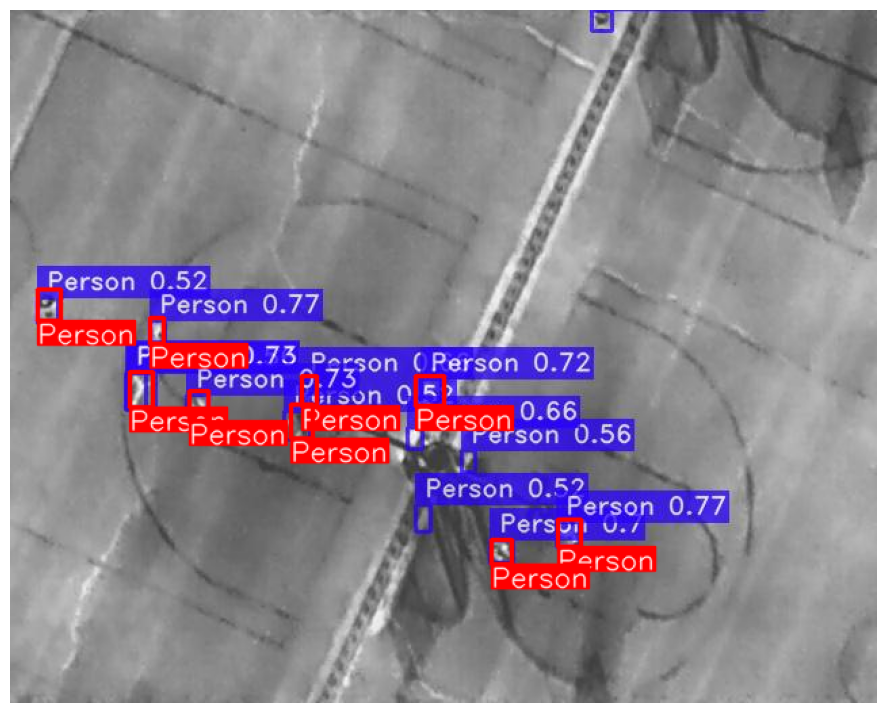

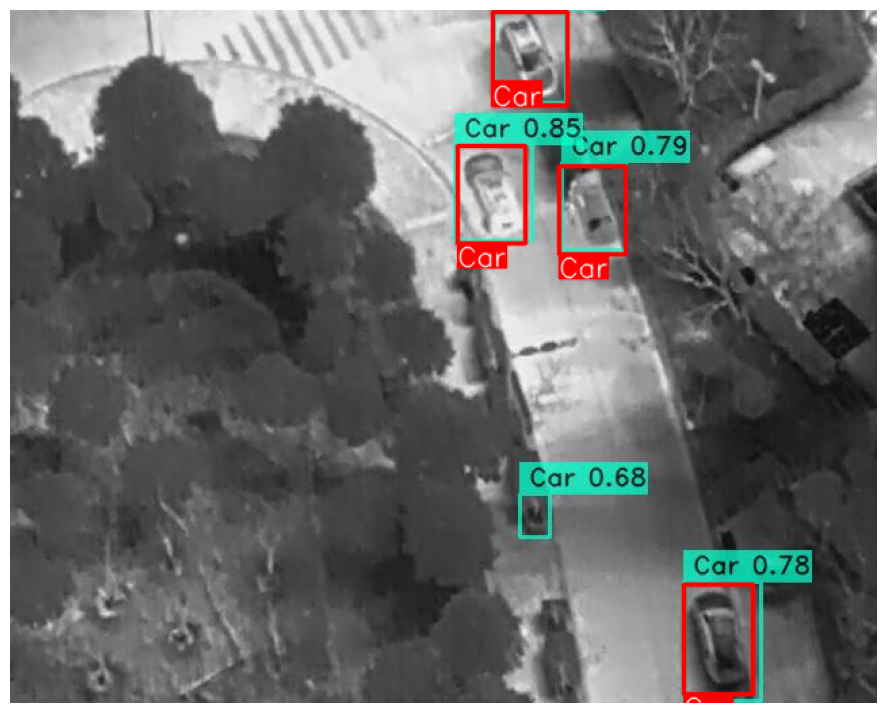

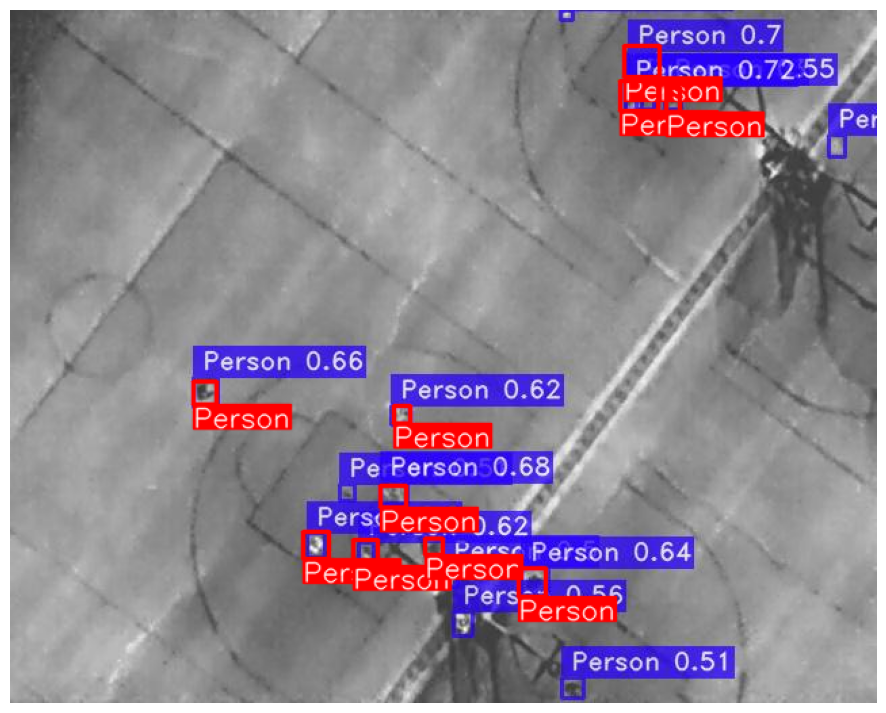

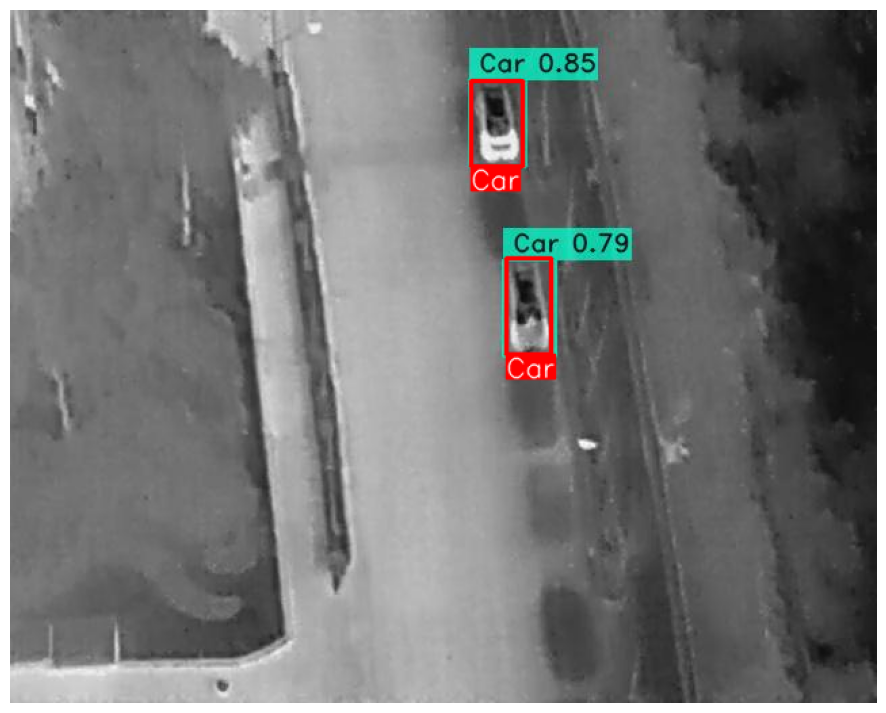

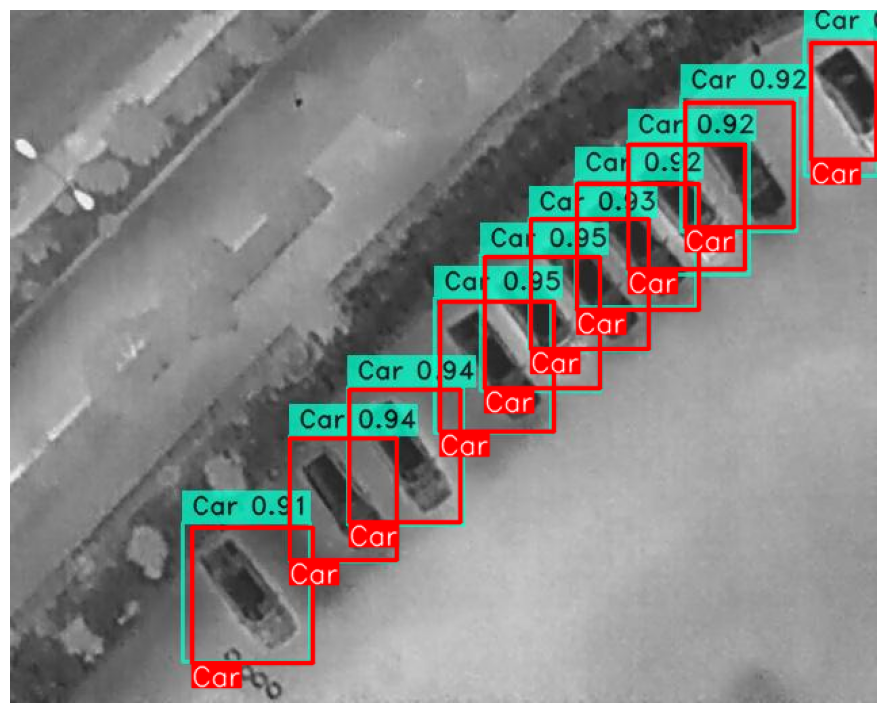

In [ ]:
# Visualize a few training images.
plot(
    image_path='inference_results/images/',
    label_path='hit-uav/labels/test/',
    num_samples=5,
)